# Looking at the "Coadd Catalogs": merged tract-patch catalogs in Run 1.1p leading up to DC2
Michael Wood-Vasey

Purpose:
Demonstrate reading a static-sky catalog from photometry on the coadd images based on a merged coadd catalog.  Shows the example of plotting a color-color stellar locus against the data to demonstrate some basic use of the magnitudes and extendedness columns.

Notes:
This Notebook is intended to be run through the JupyterHub NERSC interface available at https://jupyter-dev.nersc.gov:
 * Run at NERSC from a clone of the DC2_Repo.
 * Run from the `DC2_Repo/Notebook` directory.

In [1]:
import os

import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

import pandas as pd

In [2]:
# Some plotting choices
plt.rcParams['figure.figsize'] = (8, 8)

# cmap = 'Oranges'
cmap = 'viridis_r'

In [3]:
merged_tract_data_dir = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.1/coadd_catalog/'

In [4]:
tract, patch = 4849, 16
basename = 'merged_tract_%d.hdf5' % tract
key = 'coadd_%d_%2d' % (tract, patch)

In [5]:
merged_tract_file = os.path.join(merged_tract_data_dir, basename)

In [6]:
df = pd.read_hdf(merged_tract_file, key=key)

In [7]:
print(len(df), "coadd objects")

15958 coadd objects


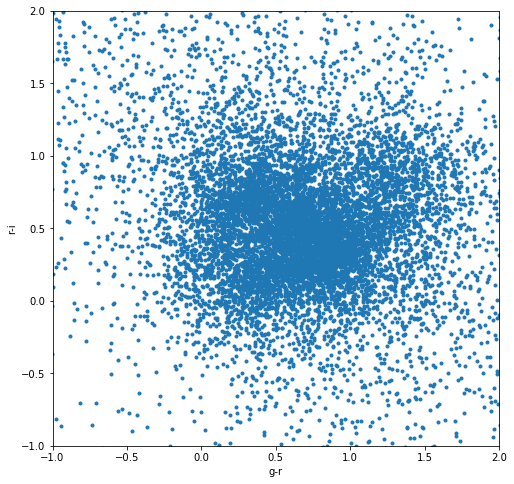

In [8]:
plt.figure(figsize=(8,8))
plt.scatter(df['g_mag'] - df['r_mag'], df['r_mag'] - df['i_mag'], marker='.')
plt.xlim(-1, +2)
plt.ylim(-1, +2)
plt.xlabel('g-r')
plt.ylabel('r-i')

That's a bit of a mess, but maybe we're starting to see a bit of some structure resolving.  Let's do the traditional simple 2D histogram version:

Let's overplot a rough stellar locus.  This is just a simple approximation with two lines.  See, e.g., Ivezic+2007, AJ, 134, 973. Fig. 3 (http://iopscience.iop.org/article/10.1086/519976/pdf)

In [9]:
def simple_stellar_locus_gmr_rmi(color='red', linestyle='--', linewidth=2.5):
    """Provide a simple two-slope definition of a stellar locus in (g-r, r-i).
    
    This simply defines one vertical line for M stars
    and the general slope for the bluer stars."""
    m_stars_gmr = [+1.4, +1.4]  # mag
    m_stars_rmi = [+0.5, +1.5]

    other_stars_gmr = [-0.5, +1.4]
    other_stars_rmi = [-0.4, +0.5]

    model_gmr = other_stars_gmr + m_stars_gmr
    model_rmi = other_stars_rmi + m_stars_rmi
    
    return model_gmr, model_rmi

    
def get_stellar_locus_davenport(color1='gmr', color2='rmi',
                                datafile='Davenport_2014_MNRAS_440_3430_table1.txt'):
    data = pd.read_table(datafile, sep='\s+', header=1)
    return data[color1], data[color2]
    
    
def plot_stellar_locus(color1='gmr', color2='rmi',
                       color='red', linestyle='--', linewidth=2.5):
    model_gmr, model_rmi = get_stellar_locus_davenport(color1, color2)
    plot_kwargs = {'linestyle': linestyle, 'linewidth': linewidth, 'color': color,
                   'scalex': False, 'scaley': False}
    plt.plot(model_gmr, model_rmi, **plot_kwargs)

In [10]:
def plot_color_color(z, color1, color2, range1=(-1, +2), range2=(-1, +2), bins=31):
    """Plot a color-color diagram.  Overlay stellar locus"""
    band1, band2 = color1[0], color1[-1]
    band3, band4 = color2[0], color2[-1]
    H, xedges, yedges = np.histogram2d(
        z['%s_mag' % band1] - z['%s_mag' % band2],
        z['%s_mag' % band3] - z['%s_mag' % band4],
        range=(range1, range2), bins=bins)
        
    zi = H.T
    xi = (xedges[1:] + xedges[:-1])/2
    yi = (yedges[1:] + yedges[:-1])/2

    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xi, yi, zi, cmap=cmap)
    plt.contour(xi, yi, zi)
    plt.xlabel('%s-%s' % (band1, band2))
    plt.ylabel('%s-%s' % (band3, band4))

    plot_stellar_locus(color1, color2)

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/numpy/lib/function_base.py:973: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


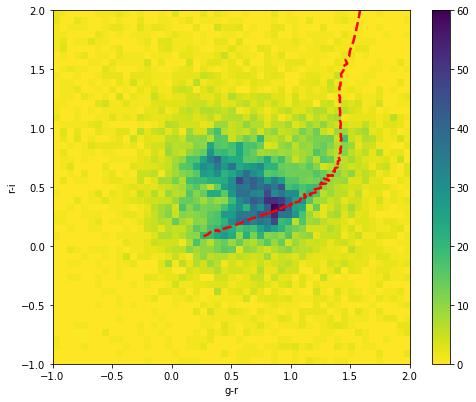

In [11]:
plt.figure(figsize=(8,6.5))
plt.hist2d(df['g_mag']-df['r_mag'], df['r_mag']-df['i_mag'],
           cmap=cmap, range=((-1, +2), (-1, +2)), bins=51)
plt.colorbar()
plt.xlabel('g-r')
plt.ylabel('r-i')

plot_stellar_locus('gmr', 'rmi')

### Restrict at "good" sources
Clean this up a bit to define
 1. objects with SNR > 25 in g and r.
 2. stars from this SNR > 25 sample.
 3. bright-star set consistent with the usage in the LSST SRD of stars with SNR~100 (although that threshold may arguably be meant to be on the SNR in individual images).

In [12]:
snr_threshold = 25
mag_err_threshold = 1/snr_threshold
good_snr = df[(df['g_mag_err'] < mag_err_threshold) & (df['r_mag_err'] < mag_err_threshold)]

In [13]:
bright_snr_threshold = 100
mag_err_threshold = 1/bright_snr_threshold
bright_stars = df[(df['g_mag_err'] < mag_err_threshold) & (df['r_mag_err'] < mag_err_threshold)]

In [14]:
safe_max_extended = 1.0
stars = good_snr[good_snr['base_ClassificationExtendedness_value'] < safe_max_extended]
galaxies = good_snr[good_snr['base_ClassificationExtendedness_value'] >= safe_max_extended]

In [15]:
print("%d stars (SNR > %.0f)" % (len(stars), snr_threshold))
print("%d bright stars (SNR > %.0f)" % (len(bright_stars), bright_snr_threshold))

523 stars (SNR > 25)
509 bright stars (SNR > 100)


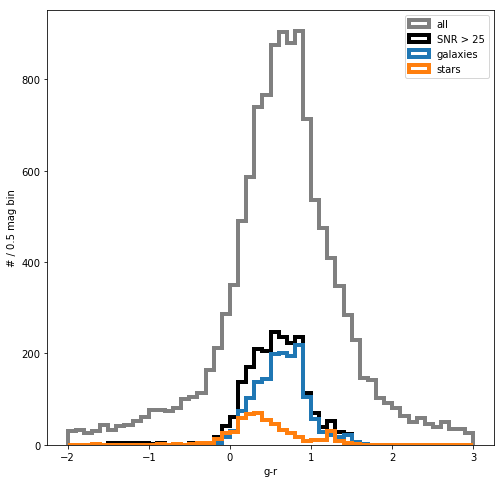

In [16]:
hist_kwargs = {'bins': np.linspace(-2, 3, 51),
               'range': (-2, +3),
               'linewidth': 4,
               'histtype': 'step'}
          
plt.hist(df['g_mag'] - df['r_mag'], label='all', color='grey', **hist_kwargs)
plt.hist(good_snr['g_mag'] - good_snr['r_mag'], label='SNR > %.0f' % snr_threshold, color='black',
         **hist_kwargs)
plt.hist(galaxies['g_mag'] - galaxies['r_mag'], label='galaxies', **hist_kwargs)
plt.hist(stars['g_mag'] - stars['r_mag'], label='stars', **hist_kwargs)
plt.xlabel('g-r')
plt.ylabel('# / 0.5 mag bin')
plt.legend()

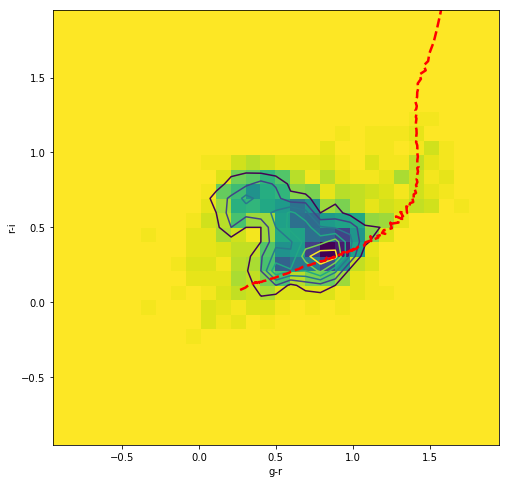

In [17]:
plot_color_color(galaxies, 'gmr', 'rmi')

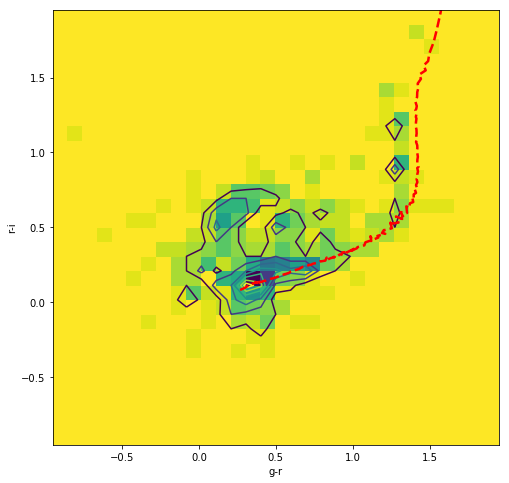

In [18]:
plot_color_color(stars, 'gmr', 'rmi')

(15, 28)

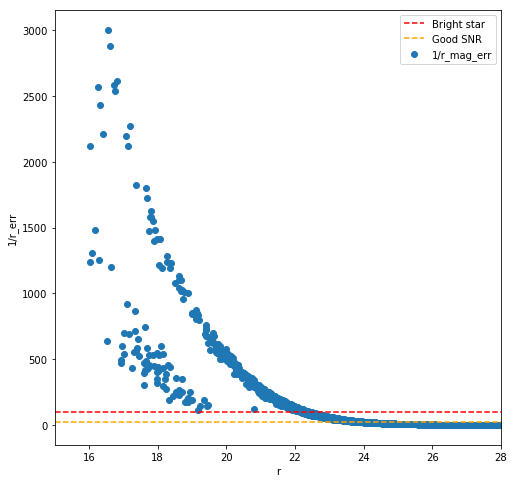

In [19]:
plt.scatter(df['r_mag'], 1/df['r_mag_err'], label='1/r_mag_err')
plt.xlabel('r')
plt.ylabel('1/r_err')
plt.axhline(bright_snr_threshold, linestyle='--', color='red', label='Bright star')
plt.axhline(snr_threshold, linestyle='--', color='orange', label='Good SNR')
plt.legend()
plt.xlim(15, 28)
# plt.ylim(0, 1.0)

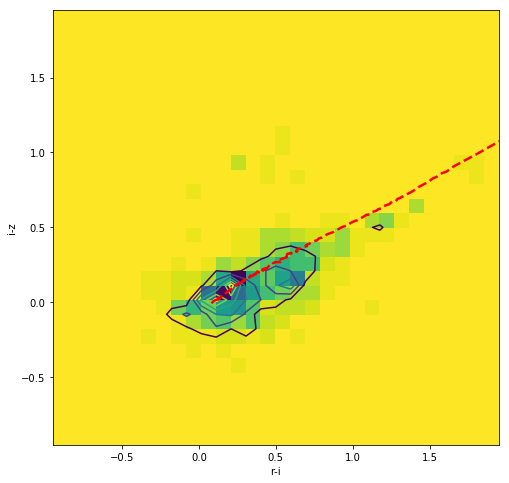

In [20]:
plot_color_color(stars, 'rmi', 'imz')

See, e.g., http://www.astroml.org/examples/datasets/plot_sdss_imaging.html

(25, 15)

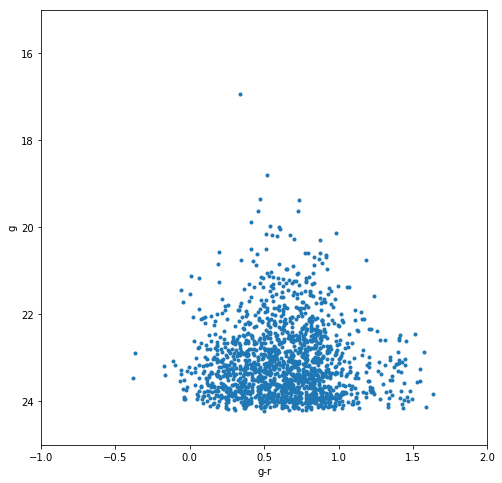

In [21]:
z = galaxies
plt.scatter(z['g_mag'] - z['r_mag'], z['g_mag'], marker='.')
plt.xlabel('g-r')
plt.ylabel('g')
plt.xlim(-1, +2)
plt.ylim(25, 15)

(25, 15)

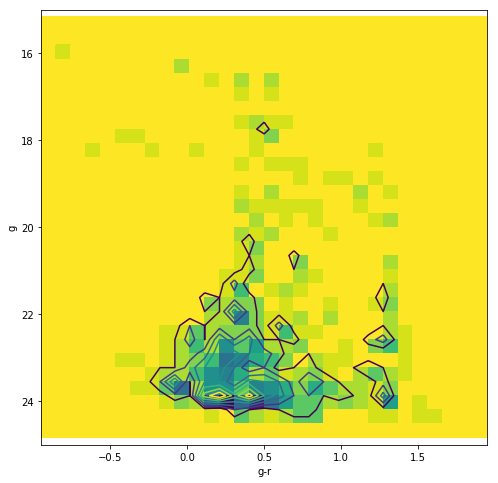

In [22]:
z = stars
H, xedges, yedges = np.histogram2d(z['g_mag']-z['r_mag'], z['g_mag'],
                                    range=((-1, +2), (15, 25)), bins=31)
zi = H.T
xi = (xedges[1:] + xedges[:-1])/2
yi = (yedges[1:] + yedges[:-1])/2

plt.pcolormesh(xi, yi, zi, cmap=cmap)
plt.contour(xi, yi, zi)
plt.xlabel('g-r')
plt.ylabel('g')
plt.ylim(25, 15)

## Appendix

## Generic Catalog Reader (GCR)

After a little bit you'll find yourself wanting to ask interesting questions, like how well does the DC2 analysis recover the input sources?  Or easily loading in all of the patches of a tract.  A convenient framework for generalizing analyses of DESC-DC related catalogs is the Generic Catalog Reader:

* GCR is a general utility
https://github.com/yymao/generic-catalog-reader
* The catalogs supporting DC2 are in:
https://github.com/LSSTDESC/gcr-catalogs

See the "DC2 Coadd Run1.1p GCR tutorial" series!

## Density Estimation (unfinished)
We could entertain ourselves by doing a somewhat better density estimation
E.g., a Gaussian kernel density estimation.

https://stackoverflow.com/questions/19390320/scatterplot-contours-in-matplotlib